# Skin Cancer Detection using CNN

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## 1. Data Reading/Data Understanding

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 1.1 Init data paths

In [3]:
## If you are using the data by mounting the google drive, use the following :
#from google.colab import drive
#drive.mount('/content/gdrive')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
#data_dir_train = pathlib.Path("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train")
#data_dir_test = pathlib.Path('gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Test')
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

89
118


## 2. Dataset creation

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### 2.1 Create the dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Created train dataset with 80% of images. seed used is 123 and images are resized to 180*180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), subset="training", validation_split=0.2, seed=123)

Found 89 files belonging to 9 classes.
Using 72 files for training.


In [8]:
## Created validation dataset with 20% of images. seed used is 123 and images are resized to 180*180
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), subset="validation", validation_split=0.2, seed=123)

Found 89 files belonging to 9 classes.
Using 17 files for validation.


In [9]:
# Class names available in train dataset.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Dataset visualisation
Visualize one instance of all the nine classes present in the dataset

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

: 

: 

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building & training - I

### 4.1 Create the model
- Create a CNN model, which can accurately detect 9 classes present in the dataset. 
- Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Get total number of classes available
num_classes = len(class_names)

# Create a Sequential model 
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

### 4.2 Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
# Compile the model using `adam` as optimiser and `tf.keras.losses.SparseCategoricalCrossentropy` as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 4.3 Train the model using 20 epochs

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 1s 242ms/step - loss: 2.8223 - accuracy: 0.0972 - val_loss: 2.2203 - val_accuracy: 0.1765
Epoch 2/20
3/3 [==============================] - 0s 112ms/step - loss: 2.3793 - accuracy: 0.0833 - val_loss: 2.2358 - val_accuracy: 0.0588
Epoch 3/20
3/3 [==============================] - 0s 158ms/step - loss: 2.2114 - accuracy: 0.1389 - val_loss: 2.2560 - val_accuracy: 0.1765
Epoch 4/20
3/3 [==============================] - 0s 110ms/step - loss: 2.1776 - accuracy: 0.1389 - val_loss: 2.1773 - val_accuracy: 0.1176
Epoch 5/20
3/3 [==============================] - 0s 185ms/step - loss: 2.1073 - accuracy: 0.1944 - val_loss: 2.1938 - val_accuracy: 0.1765
Epoch 6/20
3/3 [==============================] - 0s 112ms/step - loss: 2.0347 - accuracy: 0.2639 - val_loss: 2.2153 - val_accuracy: 0.1765
Epoch 7/20
3/3 [==============================] - 0s 166ms/step - loss: 1.9937 - accuracy: 0.2361 - val_loss: 2.1950 - val_accuracy: 0.0588
Epoch 8/20
3/3 [====

### 4.4 Visualize the training results

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

: 

: 

### 4.5 Observations: 
 - After 20 epochs, training accuracy is ~87% and validation accuracy is ~54%.
 - There's big difference between training and validation acuracy.
 - Difference between Training and validation loss also high. 
 - These are clear symptoms for overfitting.
 - Validation accuracy is 54% which is very low.

## 5. Data augmentation

In [ ]:
# Augment the images to overcome the overfitting.
# Added RandomFlip, RandomRotation and RandomZoom layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

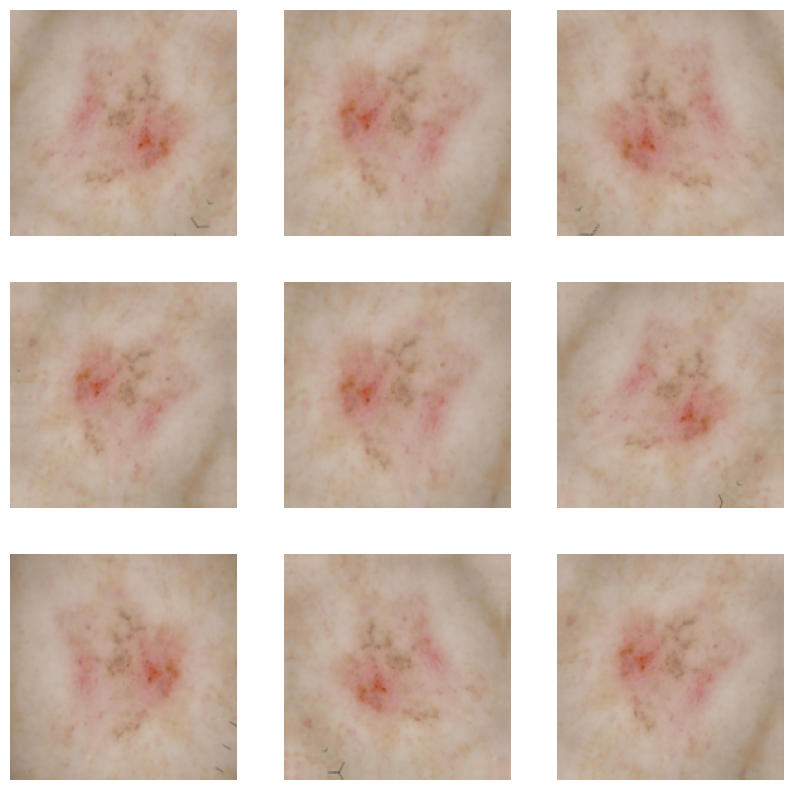

In [ ]:
# Visualize the augmented images
plt.figure(figsize=(10,10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

## 6. Model Building & training - II

### 6.1 Create the model with data augmentation and Dropout


In [ ]:
## Added data augmentattion layers
## Added Dropout to reduce overfitting

## Your code goes here
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

### 6.2 Compile the model

In [ ]:
# Compile the model using `adam` as optimiser and `tf.keras.losses.SparseCategoricalCrossentropy` as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### 6.3 Train the model using 20 epochs

In [ ]:
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
57/57 [==============================] - 5s 37ms/step - loss: 2.2275 - accuracy: 0.1978 - val_loss: 1.9992 - val_accuracy: 0.2695
Epoch 2/20
57/57 [==============================] - 2s 32ms/step - loss: 1.9449 - accuracy: 0.2744 - val_loss: 1.9946 - val_accuracy: 0.2584
Epoch 3/20
57/57 [==============================] - 2s 30ms/step - loss: 1.7801 - accuracy: 0.3467 - val_loss: 1.6578 - val_accuracy: 0.4076
Epoch 4/20
57/57 [==============================] - 2s 31ms/step - loss: 1.6032 - accuracy: 0.4339 - val_loss: 1.6460 - val_accuracy: 0.4276
Epoch 5/20
57/57 [==============================] - 2s 31ms/step - loss: 1.4994 - accuracy: 0.4844 - val_loss: 1.6876 - val_accuracy: 0.4053
Epoch 6/20
57/57 [==============================] - 2s 30ms/step - loss: 1.4927 - accuracy: 0.4789 - val_loss: 1.3901 - val_accuracy: 0.5145
Epoch 7/20
57/57 [==============================] - 2s 31ms/step - loss: 1.3896 - accuracy: 0.5100 - val_loss: 1.3923 - val_accuracy: 0.5056
Epoch 8/20
57

### 6.4 Visualize the training results

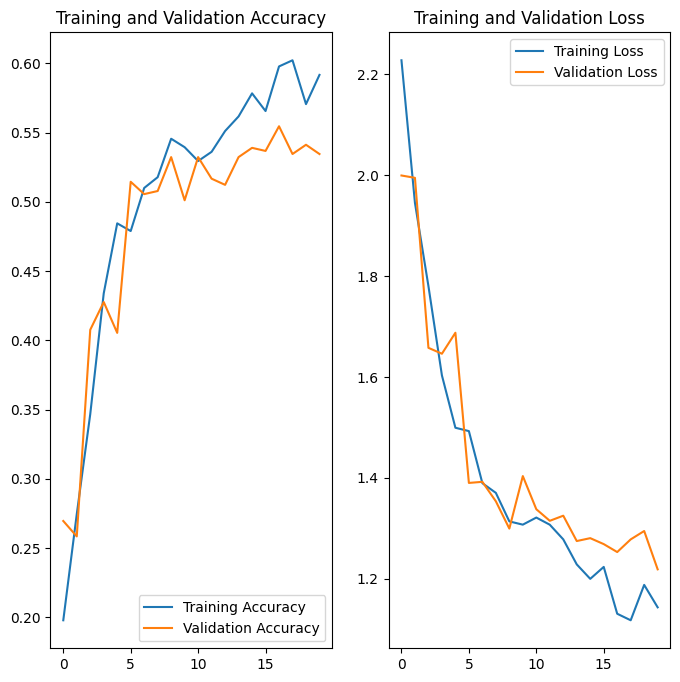

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6.5 Observations: 
 - After 20 epochs, training accuracy is ~59% and validation accuracy is ~53%.
 - Difference between training and validation acuracy reduced.
 - Difference between Training and validation loss also reduced. 
 - Overfitting issue is improved with this model.
 - Training and Validation accuracy is are very low.
 - Symptoms point to underfitting.

## 7. Class distribution

### 7.1 Class distribution in training dataset

In [ ]:
def distribution_of_classes(directory):    
    image_count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            image_count.append(len([name for name in os.listdir(path)
            if os.path.isfile(os.path.join(path, name))]))
    
    class_names = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    return pd.DataFrame(list(zip(class_names, image_count)),columns =['Class Name', 'Image Count'])

class_distribution_df = distribution_of_classes(data_dir_train)
class_distribution_df

,Class Name,Image Count
0,vascular lesion,139
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,pigmented benign keratosis,462
4,nevus,357
5,melanoma,448
6,dermatofibroma,95
7,basal cell carcinoma,376
8,actinic keratosis,114


<Axes: xlabel='Image Count', ylabel='Class Name'>

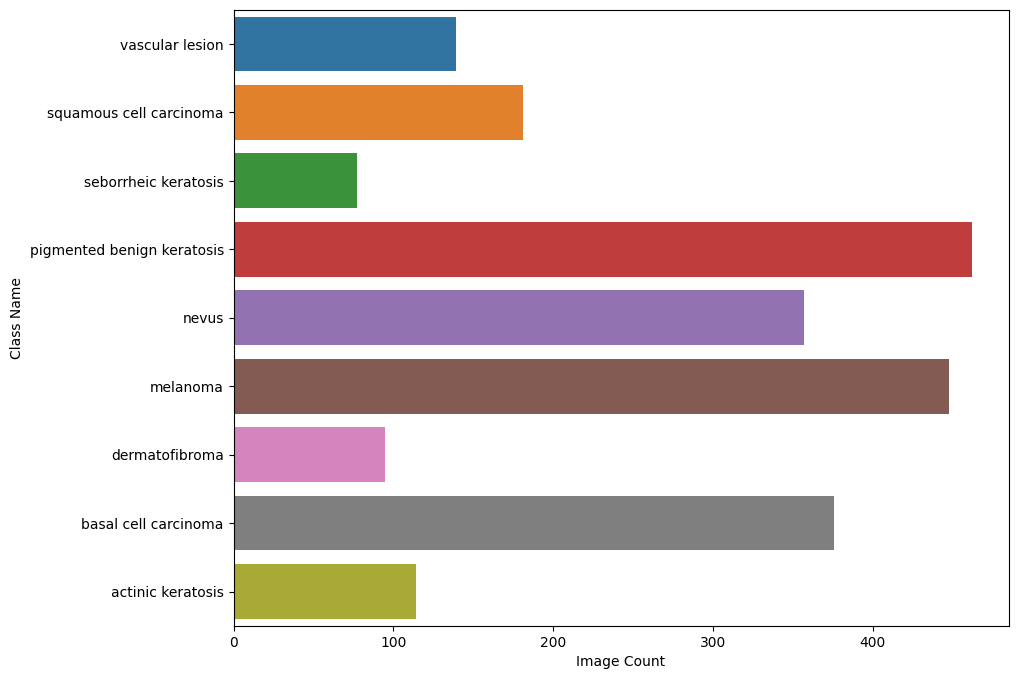

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="Image Count", y="Class Name", data=class_distribution_df,
            label="Class")

### 7.2 Observations: 
 - `seborrheic keratosis` has the least number of samples.
 - `pigmented benign keratosis` dominate the data in terms proportionate number of samples.


## 8. Handling class imbalances

### 8.1 Rectify the class imbalance
Used [Augmentor](https://augmentor.readthedocs.io/en/master/) python package to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B871F6A0>: 100%|██████████| 500/500 [00:25<00:00, 19.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B8585610>: 100%|██████████| 500/500 [00:29<00:00, 16.97 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B84D0FA0>: 100%|██████████| 500/500 [00:23<00:00, 21.18 Samples/s]


Initialised with 448 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F77B8593A60>: 100%|██████████| 500/500 [02:02<00:00,  4.09 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1028x753 at 0x7F77B8656EB0>: 100%|██████████| 500/500 [01:38<00:00,  5.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B8786FA0>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F77B857F310>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F77B8676CD0>: 100%|██████████| 500/500 [00:21<00:00, 22.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B8A45490>: 100%|██████████| 500/500 [00:23<00:00, 21.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.
Print total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### 8.2 Distribution of augmented data after adding new images to the original training data.

In [ ]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_30a05cf1-7cd0-43ec-8897-e6c1f9f3d8d0.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output/vascular lesion_original_ISIC_0032270.jpg_f5f2e8d4-9e8e-4f0d-ada9-2fa865fbfd8f.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output/vascular lesion_original_ISIC_0026163.jpg_d2bdd5a1-1d95-403b-b034-162703b4c95e.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output/vascular lesion_original_ISIC_0024867.jpg_e691a4b8-8c7c-4452-983b-201c96ad7999.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration 1/Train/vascular lesion/output/vascular lesion_original_ISIC_0027888.jpg_86e3b7c8-a3fc-4185-8599-3a9a618e16f0.jpg',
 'gdrive/My Drive/Sk

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
df2['Label'].value_counts()

vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
nevus                         500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 9. Model Building & training - III

### 9.1 Create the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### 9.2 Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


### 9.3 Create the model with augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [ ]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

#### 9.4 Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

### 9.5 Train the model using 50 epochs

In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 38s 204ms/step - loss: 1.8225 - accuracy: 0.3056 - val_loss: 1.5314 - val_accuracy: 0.4151
Epoch 2/50
169/169 [==============================] - 37s 205ms/step - loss: 1.5216 - accuracy: 0.4204 - val_loss: 1.5302 - val_accuracy: 0.4337
Epoch 3/50
169/169 [==============================] - 40s 221ms/step - loss: 1.3727 - accuracy: 0.4806 - val_loss: 1.3660 - val_accuracy: 0.4893
Epoch 4/50
169/169 [==============================] - 35s 201ms/step - loss: 1.3042 - accuracy: 0.5106 - val_loss: 1.3092 - val_accuracy: 0.4959
Epoch 5/50
169/169 [==============================] - 37s 210ms/step - loss: 1.2655 - accuracy: 0.5237 - val_loss: 1.2322 - val_accuracy: 0.5271
Epoch 6/50
169/169 [==============================] - 35s 201ms/step - loss: 1.1928 - accuracy: 0.5437 - val_loss: 1.1599 - val_accuracy: 0.5656
Epoch 7/50
169/169 [==============================] - 37s 206ms/step - loss: 1.1207 - accuracy: 0.5809 - val_loss: 1.1784 - val_ac

### 9.6 Visualize the model results

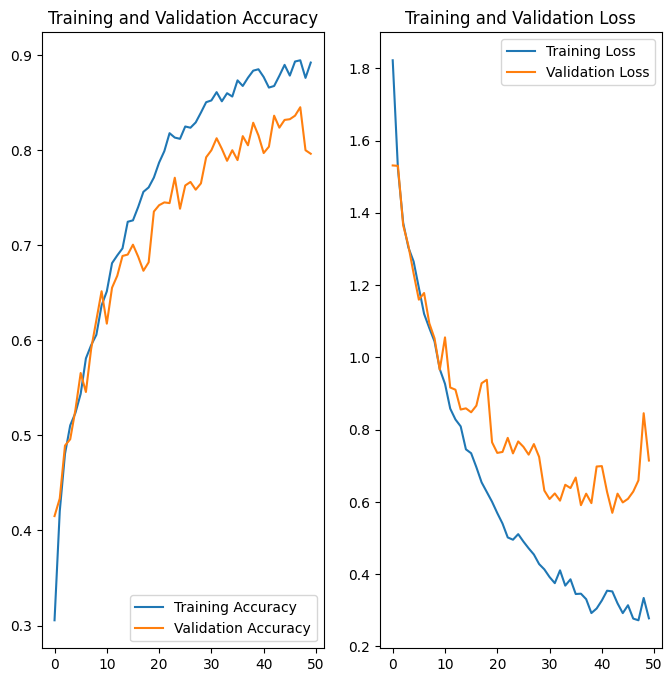

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9.7 Observations: 
 - After 50 epochs, training accuracy is ~89% and validation accuracy is ~79%.
 - Difference between training and validation acuracy better.
 - Difference between Training and validation loss also become better. 
 - Overfitting and Underfitting issue are improved with this model.
 - Accuracy and loss are better with this model.

